# Group Project 4

# Air Quality and Mortality

imports 

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os


from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# variance inflation factor
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Overview

Pollution has long been known to have a causal effect on negative health outcomes. Our group's goal was to use various statistical hypothesis tests as well as exploratory data analysis and regression analysis to gain a stronger quantitative understanding of the effects of air pollution amongst the 58 counties of California. 

### EPA Air Quality Data Overview

Our primary data source and point of departure for all subsequent analysis is EPA air quality data. The EPA monitors and collects data on air pollution in every major city in United States. The air quality data is aggregated in varying levels of granularity. From this collection process, the EPA calculates the Air Quality Index, a measurement of overall danger to health that ranges from 0 (none) to 500 (maximum danger) The AQI is calculated by taking the highest average measurement of each of the constituent pollution factors being monitored, and weighs it by known health effects. 

At the more coarse annual level, we find our chosen dataset: the aggregate level of monitored pollutants, per day, for each County in the United States. 

We collected and cleaned this data from the EPA's website [[SOURCE](https://aqs.epa.gov/aqsweb/airdata/download_files.html#Annual)]. The major air quality metrics monitored are:

1. Days NO2 - Nitrogen Dioxide, also known as Nitrogen Oxide (NO_X). The primary source of atmospheric nitrogen dioxide is the burning of fossil fuels.

2. Days Ozone - While stratospheric ozone is known to be a good thing due to its blocking of harmful ultraviolet radiation, ground-level ozone has been found to cause a number of health problems. 

3. Days PM2.5 - Fine particulate matter with a diameter 2.5 micrometers or smaller. This matter often emanates from dust stirred up from a construction site or field, or incomplete combustion (smoke) from smoke stacks or a forest fire. PM 2.5 particulate matter is often associated with haze, and, when inhaled, embeds deep in the lungs. 

4. Days PM10 - Coarse particulate matter. Also emanating from dust producing sources as well as incomplete combustion (smoke).

5. Days CO - Carbon Monoxide. Produced by the combustion of fossil fuels and causes a number of lung ailments from fatigue through death. 

### Health Effects and Mortality

Our group chose to trifurcate the analysis of social impact. This notebook's purpose is to analyze the impact of harmful atmospheric pollution on mortality in California, analyzed at the county-level, over a time scale ranging from 1999-2021, using data collected from the California Department of Public Health's county death profiles [[SOURCE](https://data.chhs.ca.gov/dataset/statewide-death-profiles)].

California classifies causes of death using the World Health Organization's International Classification of Diseases. Obviously multiple sources of death can occur at once, CHHS uses the WHO's guidance, listing "the disease or injury which initiated the train of events leading directly to death, or the circumstances of the accident or violence which produced the fatal injury." The major causes of death are listed below:

| Abbreviation | Cause of Death |
| --- | --- |
| ALL | All causes (total) |
| ALZ | Alzheimer's disease [G30] |
| CAN | Malignant neoplasms (cancers) [C00-C97] |
| CLD | Chronic lower respiratory disease (CLRD) [J40-J47] |
| DIA | Diabetes mellitus [E10-E14] |
| HOM | Assault (homicide) [*U01-*U02, X85-Y09, Y87.1] |
| HTD | Diseases of heart [I00-I09, I11, I13, I20-I51] |
| HYP | Essential hypertension and hypertensive renal disease [I10, I12, I15] |
| INJ | Accidents (unintentional injuries) [V01-X59, Y85-Y86] |
| LIV | Chronic liver disease and cirrhosis [K70, K73-K74] |
| NEP | Nephritis, nephrotic syndrome and nephrosis [N00-N07, N17-N19, N25-N27] |
| PAR | Parkinson's disease [G20-G21] |
| PNF | Pneumonia and influenza [J09-J18] |
| STK | Cerebrovascular disease (stroke) [I60-I69] |
| SUI | Intentional self-harm (suicide) [*U03, X60-X84, Y87.0] |

Of these causes of death, the EPA's air quality literature lists that the primary sources of ailment stemming from toxic air pollution are Cancer, Heart Disease and Respiratory Illnesses. Thus, we will select for the following four codes from the CHHS mortality tables, Cancer, Heart Disease, Pneumonia and Chronic Lower Respiratory Disease. 

---
Sources
1. https://www.epa.gov/outdoor-air-quality-data/about-air-data-reports
2. https://www.epa.gov/ground-level-ozone-pollution
3. https://www.epa.gov/pm-pollution/particulate-matter-pm-basics
4. https://www.epa.gov/sites/default/files/2014-05/documents/huff-particle.pdf
5. https://www3.epa.gov/region1/airquality/co.html

# I. Arrange and Clean Data

In [62]:
# # read in each CSV file in air_quality_data directory and concatenate them into one dataframe
air_quality_data = pd.concat([pd.read_csv('../air_quality_data/{}'.format(file)) for file in os.listdir('../air_quality_data')])

# daily air quality data
air_quality_data_daily = pd.concat([pd.read_csv('../daily_air_quality_data/{}'.format(file), low_memory=False) for file in os.listdir('../daily_air_quality_data')])

# life expectancy data by CA county
life_expectancy = pd.read_csv('../health_data/Vital_Signs_Life_Expectancy_by_county.csv')

# mortality tables for CA counties from 2014-2022
mortality = pd.read_csv('../health_data/mortality.csv')

# mortality tables for CA counties from 1999-2013
mortality_2 = pd.read_csv('../health_data/99-13_mortality.csv')

# concatenate the two mortality tables
mortality = pd.concat([mortality, mortality_2]).sort_values(by='Year').reset_index(drop=True)

# rename Year to Date
mortality.rename(columns={'Year':'Date'}, inplace=True)

# monthly mortality data 
mortality_data_monthly = pd.concat([pd.read_csv('../monthly_health_data/{}'.format(file)) for file in os.listdir('../monthly_health_data')])



**Datasets**

We gathered annual and monthly mortality data from CHHS for all 58 counties in California for a time period spanning from 1999 to 2021. 

For the same time period and counties, we collected daily and annual EPA air quality data.

# I. Data Cleaning 

In [63]:
# filter for only California 
ca_df = air_quality_data.query('State == "California"').copy()

# Set the index to be the year
ca_df.set_index('Year', inplace=True)

# rename Year to Date
ca_df.index.rename('Date', inplace=True)

# annual air quality data
ca_df = ca_df.query('`Days with AQI` > 360').copy()

# daily air quality data
ca_df_daily = air_quality_data_daily.query('`State Name` == "California"').copy()

# datetime index
ca_df_daily.set_index(pd.to_datetime(ca_df_daily['Date']), inplace=True)

# daily to monthly
ca_df_daily = ca_df_daily.groupby('county Name').resample('MS').mean()

# rename index to 'County'
ca_df_daily.index.rename('County', level=0, inplace=True)

DateTime Index for Monthly Mortality Data

In [64]:
# combine Year and Month columns into a single column, then convert to datetime object and set as index

mortality_data_monthly['Year'] = mortality_data_monthly['Year'].astype(str)
mortality_data_monthly['Month'] = mortality_data_monthly['Month'].astype(str)
mortality_data_monthly['Date'] = mortality_data_monthly['Year'] + '-' + mortality_data_monthly['Month'] + '-01'
mortality_data_monthly['Date'] = pd.to_datetime(mortality_data_monthly['Date'])
mortality_data_monthly.set_index('Date', inplace=True)

# drop Year and Month columns
mortality_data_monthly.drop(['Year', 'Month'], axis=1, inplace=True)

A useable datatime index is parsed from separate year and month columns. 

# Annual and Monthly DataFrames for 4 major Mortalities

In [65]:
# deaths likely attributable to air pollution
respiratory_diseases = ['CLD', 'CAN', 'PNF', 'HTD']

In [66]:
# create a df for each disease

# chronic lower respiratory diseases
cld = mortality.query('Cause == "CLD" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

cld_monthly = mortality_data_monthly.query('Cause == "CLD" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

# cancer
can = mortality.query('Cause == "CAN" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

can_monthly = mortality_data_monthly.query('Cause == "CAN" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

# pneumonia
pneumonia = mortality.query('Cause == "PNF" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

pneumonia_monthly = mortality_data_monthly.query('Cause == "PNF" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

# heart disease
heart_disease = mortality.query('Cause == "HTD" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

heart_disease_monthly = mortality_data_monthly.query('Cause == "HTD" and Strata == "Total Population" and Geography_Type == "Residence"').copy()


For the four major EPA outlined sources of disease, we create an individual data frame from the mortality tables. 

# Merge with EPA DATA

In [67]:
# Days with AQI is a measure of the number of days in a year with valid air quality data, so we'll filter for only counties with at least 360 days of data
ca_df = ca_df.query('`Days with AQI` > 360').copy()

# merge cld and ca_df
cld = cld.merge(ca_df, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])

cld_monthly = cld_monthly.merge(ca_df_daily, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])

# merge can and ca_df
can = can.merge(ca_df, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])

can_monthly = can_monthly.merge(ca_df_daily, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])

# merge pneumonia and ca_df
pneumonia = pneumonia.merge(ca_df, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])

pneumonia_monthly = pneumonia_monthly.merge(ca_df_daily, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])

# merge heart_disease and ca_df
heart_disease = heart_disease.merge(ca_df, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])

heart_disease_monthly = heart_disease_monthly.merge(ca_df_daily, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])


We then merge the EPA and mortality data on County and Data so that we can more easily make county level comparisons between EPA air pollution statistics and health outcomes. 

### Missing Values, Data Imputation , NaN's

Cancer + EPA

In [68]:
display(can.describe())
print(can.isnull().sum())

,Date,Count,Annotation_Code,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
count,1334.000000,1284.000000,50.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000
mean,2010.000000,1011.313863,1.080000,364.991682,209.500924,114.238447,28.978743,10.549908,1.315157,0.408503,320.408503,94.291128,51.004621,0.823475,18.749538,236.972274,96.591497,11.854898
std,6.635737,2042.287338,0.274048,0.915952,90.708653,57.343218,30.242231,18.290183,4.192802,2.359746,1180.605396,36.656282,17.509954,3.201423,31.877209,75.747250,70.686376,35.745920
min,1999.000000,0.000000,1.000000,361.000000,16.000000,4.000000,0.000000,0.000000,0.000000,0.000000,54.000000,38.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,130.000000,1.000000,365.000000,149.500000,74.000000,5.000000,0.000000,0.000000,0.000000,136.000000,65.000000,40.000000,0.000000,0.000000,192.000000,29.000000,0.000000
50%,2010.000000,339.000000,1.000000,365.000000,222.500000,111.000000,17.000000,2.000000,0.000000,0.000000,169.000000,87.000000,45.000000,0.000000,2.000000,232.000000,100.000000,2.000000
75%,2016.000000,1078.750000,1.000000,365.000000,279.000000,156.000000,44.000000,11.000000,1.000000,0.000000,203.000000,115.000000,56.750000,0.000000,24.750000,287.750000,147.000000,8.000000
max,2021.000000,14717.000000,2.000000,366.000000,361.000000,275.000000,140.000000,114.000000,51.000000,32.000000,20646.000000,209.000000,126.000000,45.000000,235.000000,366.000000,365.000000,354.000000


Date                                      0
County                                    0
Geography_Type                            0
Strata                                    0
Strata_Name                               0
Cause                                     0
Cause_Desc                                0
ICD_Revision                            870
Count                                    50
Annotation_Code                        1284
Annotation_Desc                        1284
Data_Revision_Date                      870
State                                   252
Days with AQI                           252
Good Days                               252
Moderate Days                           252
Unhealthy for Sensitive Groups Days     252
Unhealthy Days                          252
Very Unhealthy Days                     252
Hazardous Days                          252
Max AQI                                 252
90th Percentile AQI                     252
Median AQI                      

Pneumonia + EPA

In [69]:
display(pneumonia.describe())
print(pneumonia.isnull().sum())

,Date,Count,Annotation_Code,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
count,1334.000000,1051.000000,283.0,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000
mean,2010.000000,145.823977,1.0,364.991682,209.500924,114.238447,28.978743,10.549908,1.315157,0.408503,320.408503,94.291128,51.004621,0.823475,18.749538,236.972274,96.591497,11.854898
std,6.635737,327.597093,0.0,0.915952,90.708653,57.343218,30.242231,18.290183,4.192802,2.359746,1180.605396,36.656282,17.509954,3.201423,31.877209,75.747250,70.686376,35.745920
min,1999.000000,0.000000,1.0,361.000000,16.000000,4.000000,0.000000,0.000000,0.000000,0.000000,54.000000,38.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,21.000000,1.0,365.000000,149.500000,74.000000,5.000000,0.000000,0.000000,0.000000,136.000000,65.000000,40.000000,0.000000,0.000000,192.000000,29.000000,0.000000
50%,2010.000000,51.000000,1.0,365.000000,222.500000,111.000000,17.000000,2.000000,0.000000,0.000000,169.000000,87.000000,45.000000,0.000000,2.000000,232.000000,100.000000,2.000000
75%,2016.000000,140.000000,1.0,365.000000,279.000000,156.000000,44.000000,11.000000,1.000000,0.000000,203.000000,115.000000,56.750000,0.000000,24.750000,287.750000,147.000000,8.000000
max,2021.000000,2494.000000,1.0,366.000000,361.000000,275.000000,140.000000,114.000000,51.000000,32.000000,20646.000000,209.000000,126.000000,45.000000,235.000000,366.000000,365.000000,354.000000


Date                                      0
County                                    0
Geography_Type                            0
Strata                                    0
Strata_Name                               0
Cause                                     0
Cause_Desc                                0
ICD_Revision                            870
Count                                   283
Annotation_Code                        1051
Annotation_Desc                        1051
Data_Revision_Date                      870
State                                   252
Days with AQI                           252
Good Days                               252
Moderate Days                           252
Unhealthy for Sensitive Groups Days     252
Unhealthy Days                          252
Very Unhealthy Days                     252
Hazardous Days                          252
Max AQI                                 252
90th Percentile AQI                     252
Median AQI                      

Heart Disease + EPA

In [70]:
display(heart_disease.describe())
print(heart_disease.isnull().sum())

,Date,Count,Annotation_Code,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
count,1334.000000,1281.000000,53.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000
mean,2010.000000,1138.080406,1.037736,364.991682,209.500924,114.238447,28.978743,10.549908,1.315157,0.408503,320.408503,94.291128,51.004621,0.823475,18.749538,236.972274,96.591497,11.854898
std,6.635737,2484.105330,0.192380,0.915952,90.708653,57.343218,30.242231,18.290183,4.192802,2.359746,1180.605396,36.656282,17.509954,3.201423,31.877209,75.747250,70.686376,35.745920
min,1999.000000,0.000000,1.000000,361.000000,16.000000,4.000000,0.000000,0.000000,0.000000,0.000000,54.000000,38.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,134.000000,1.000000,365.000000,149.500000,74.000000,5.000000,0.000000,0.000000,0.000000,136.000000,65.000000,40.000000,0.000000,0.000000,192.000000,29.000000,0.000000
50%,2010.000000,353.000000,1.000000,365.000000,222.500000,111.000000,17.000000,2.000000,0.000000,0.000000,169.000000,87.000000,45.000000,0.000000,2.000000,232.000000,100.000000,2.000000
75%,2016.000000,1177.000000,1.000000,365.000000,279.000000,156.000000,44.000000,11.000000,1.000000,0.000000,203.000000,115.000000,56.750000,0.000000,24.750000,287.750000,147.000000,8.000000
max,2021.000000,20006.000000,2.000000,366.000000,361.000000,275.000000,140.000000,114.000000,51.000000,32.000000,20646.000000,209.000000,126.000000,45.000000,235.000000,366.000000,365.000000,354.000000


Date                                      0
County                                    0
Geography_Type                            0
Strata                                    0
Strata_Name                               0
Cause                                     0
Cause_Desc                                0
ICD_Revision                            870
Count                                    53
Annotation_Code                        1281
Annotation_Desc                        1281
Data_Revision_Date                      870
State                                   252
Days with AQI                           252
Good Days                               252
Moderate Days                           252
Unhealthy for Sensitive Groups Days     252
Unhealthy Days                          252
Very Unhealthy Days                     252
Hazardous Days                          252
Max AQI                                 252
90th Percentile AQI                     252
Median AQI                      

Chronic Lower Respiratory Disease + EPA

In [71]:
display(cld.describe())
print(cld.isnull().sum())

,Date,Count,Annotation_Code,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
count,1334.000000,1226.000000,108.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000
mean,2010.000000,244.336868,1.009259,364.991682,209.500924,114.238447,28.978743,10.549908,1.315157,0.408503,320.408503,94.291128,51.004621,0.823475,18.749538,236.972274,96.591497,11.854898
std,6.635737,445.634236,0.096225,0.915952,90.708653,57.343218,30.242231,18.290183,4.192802,2.359746,1180.605396,36.656282,17.509954,3.201423,31.877209,75.747250,70.686376,35.745920
min,1999.000000,0.000000,1.000000,361.000000,16.000000,4.000000,0.000000,0.000000,0.000000,0.000000,54.000000,38.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,42.000000,1.000000,365.000000,149.500000,74.000000,5.000000,0.000000,0.000000,0.000000,136.000000,65.000000,40.000000,0.000000,0.000000,192.000000,29.000000,0.000000
50%,2010.000000,91.000000,1.000000,365.000000,222.500000,111.000000,17.000000,2.000000,0.000000,0.000000,169.000000,87.000000,45.000000,0.000000,2.000000,232.000000,100.000000,2.000000
75%,2016.000000,251.750000,1.000000,365.000000,279.000000,156.000000,44.000000,11.000000,1.000000,0.000000,203.000000,115.000000,56.750000,0.000000,24.750000,287.750000,147.000000,8.000000
max,2021.000000,3123.000000,2.000000,366.000000,361.000000,275.000000,140.000000,114.000000,51.000000,32.000000,20646.000000,209.000000,126.000000,45.000000,235.000000,366.000000,365.000000,354.000000


Date                                      0
County                                    0
Geography_Type                            0
Strata                                    0
Strata_Name                               0
Cause                                     0
Cause_Desc                                0
ICD_Revision                            870
Count                                   108
Annotation_Code                        1226
Annotation_Desc                        1226
Data_Revision_Date                      870
State                                   252
Days with AQI                           252
Good Days                               252
Moderate Days                           252
Unhealthy for Sensitive Groups Days     252
Unhealthy Days                          252
Very Unhealthy Days                     252
Hazardous Days                          252
Max AQI                                 252
90th Percentile AQI                     252
Median AQI                      

The EPA and mortality data is fairly clean but has a lot of NaN values where particulate matter either wasn't recorded, didn't meet a threshold and thus resulted in a NaN -- for example "Hazardous Days" or did have a cause of death matching the four we're studying. To this end, we'll query our datasets for counties that have a mortality count for the selected disease greater than 0, and impute 0 for all of the EPA NaN values. 

In [72]:

# query dataframes so count is greater than 0
# chronic 
cld = cld.query('Count > 0')

# cancer
can = can.query('Count > 0')

# pneumonia
pneumonia = pneumonia.query('Count > 0')

# heart disease
heart_disease = heart_disease.query('Count > 0')

In [73]:
# impute missing values with 0

# chronic lower respiratory diseases 
cld.fillna(0, inplace=True)

# cancer
can.fillna(0, inplace=True)

# pneumonia
pneumonia.fillna(0, inplace=True)

# heart disease
heart_disease.fillna(0, inplace=True)

write cleaned data to `.csv`.

In [74]:
# write cld, can, pneumonia, and heart_disease to csv
cld.to_csv('../merged_mortality_epa_data/cld.csv', index=False)
can.to_csv('../merged_mortality_epa_data/can.csv', index=False)
pneumonia.to_csv('../merged_mortality_epa_data/pneumonia.csv', index=False)
heart_disease.to_csv('../merged_mortality_epa_data/heart_disease.csv', index=False)


---

# II. EDA

In [75]:
# matplotlib style 
plt.style.use('seaborn')

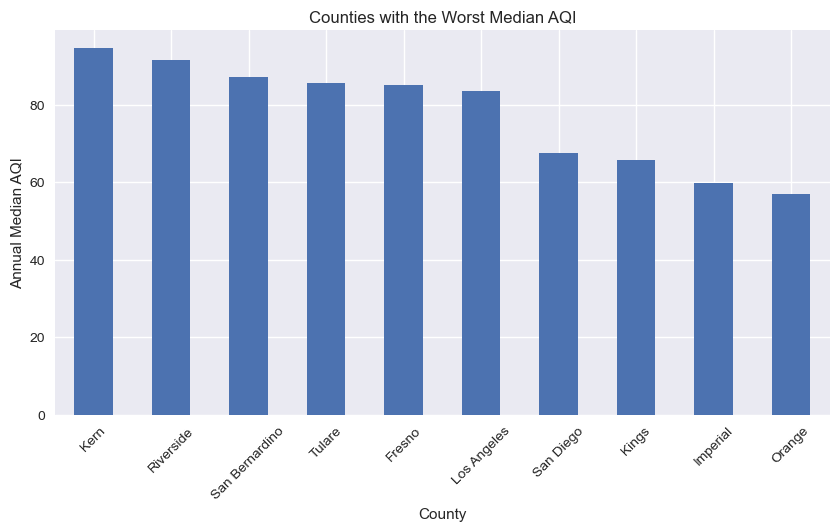

In [76]:
# counties with the most unhealthy days by Median AQI
counties_worst_air_qual = ca_df.groupby('County')['Median AQI'].mean().sort_values(ascending=False).head(10)

# plot
counties_worst_air_qual.plot(kind='bar', figsize=(10, 5), title='Counties with the Worst Median AQI')
plt.ylabel('Annual Median AQI')
plt.xticks(rotation=45);

We see that the California counties with the worst air quality, when measured by median AQI are all in Southern California, with the exception of Fresno. 

**Confluence**

Southern California faces pollution challenges due to the confluence of its geography and large population. The surrounding mountains prevent the dispersal of atmospheric pollution and in the winter months, the warm climate and prevailing easterly Santa Ana winds result in temperature inversion that blows hot air from the valley into the Los Angeles basin where pollutants become trapped at the ground level. Additionally, the massive population, suburban sprawl, frequent wildfires, and heavy industry all produce harmful emissions that feed into this system. 

Text(0.5, 1.0, 'Counties with the Worst Median AQI')

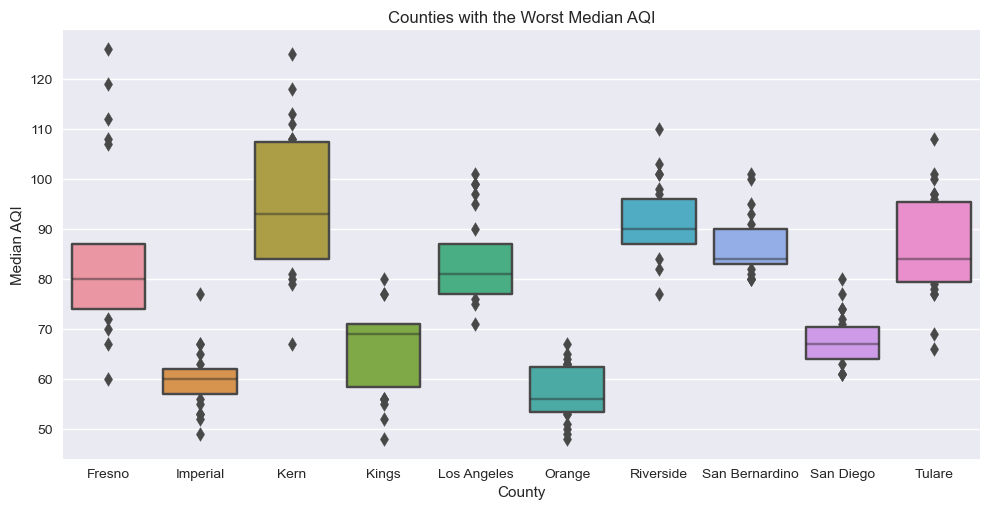

In [77]:
# tile plot of the top 10 counties with the most unhealthy days
sns.catplot(x='County', y='Median AQI', data=ca_df.query('County in @counties_worst_air_qual.index'), kind='boxen', height=5, aspect=2)
# title
plt.title('Counties with the Worst Median AQI')

In [78]:
ca_df.query('County in @counties_worst_air_qual.index').groupby('County')['Median AQI'].describe()

,count,mean,std,min,25%,50%,75%,max
County,,,,,,,,
Fresno,23.0,85.173913,17.314346,60.0,74.0,80.0,87.0,126.0
Imperial,23.0,59.826087,5.928760,49.0,57.0,60.0,62.0,77.0
Kern,23.0,94.652174,14.742051,67.0,84.0,93.0,107.5,125.0
Kings,23.0,65.739130,8.486446,48.0,58.5,69.0,71.0,80.0
Los Angeles,23.0,83.695652,8.720065,71.0,77.0,81.0,87.0,101.0
Orange,23.0,57.086957,5.384431,48.0,53.5,56.0,62.5,67.0
Riverside,23.0,91.478261,7.597066,77.0,87.0,90.0,96.0,110.0
San Bernardino,23.0,87.130435,6.040051,80.0,83.0,84.0,90.0,101.0
San Diego,23.0,67.521739,5.124536,61.0,64.0,67.0,70.5,80.0


The plot above and table of descriptive statistics shows the dispersion of Median AQI for the 10 most polluted counties in California. We see that of the 10, Kern, Riverside, San Bernardino, and Los Angeles counties have the highest Median AQI. Interestingly, Fresno has the highest Max annual Median AQI. While Fresno does not have the heavy industry or population of some of  the large Southern California counties, it is in the heart of wildfire country. Massive violent wildfires have increasingly ravaged the arid landscapes in California, producing massive amounts of lingering air pollution. 

# Granger Causality Tests

Granger causality is a time series hypothesis test that determines whether one time series has forecasting power for another time series. The general principle is one of using a set of past values for a time series $X_1$ to predict a current value of a time series $X_2$. This is done via a series of linear regression models, a linear regression model is fit to the dataset with the potential forecasting feature as the independent variable and the potential target as the dependent variable. A second linear linear regression model is then fit with the potential forecasting variable and past values of the potential target as the independent variables. If the past values of the potential target improve the second model's fit than the target can be said to have been Granger caused by the feature. 

$$
 \begin{align*}
X_1(t) = \sum_{j=1}^p{A_{11,j}X_1(t-j)} +
\sum_{j=1}^p{A_{12,j}X_2(t-j)+E_1(t)}\\
X_2(t) = \sum_{j=1}^p{A_{21,j}X_1(t-j)} +
\sum_{j=1}^p{A_{22,j}X_2(t-j)+E_2(t)}
\end{align*}
$$

We use the Granger test by comparing the major EPA pollutant measurements for each county over the 1999-2021 time scale. We will use use a $\alpha$ value of $0.05$ as the threshold to reject the null-hypothesis, thus any p-value lower than $0.05$ indicates a potential causal relationship between the cause of death and the pollutant. 

In [79]:
from statsmodels.tsa.stattools import grangercausalitytests

# Perform the Granger causality test
maxlag = 2 # number of lags to consider

# Null hypothesis: x does not Granger cause y
# Alternative hypothesis: x Granger causes y

def air_qual_test(df, air_qual_stat):
    for county in counties_worst_air_qual.index:
        try:
            # perform granger causality test
            result = grangercausalitytests(df.query(f'County == "{county}"')[['Count', air_qual_stat]], maxlag=maxlag, verbose=False)
            # get lag 1 p values
            lag1 = np.array([result[1][0][key][1] for key in result[1][0].keys()]).mean()
            # get lag 2 p values
            lag2 = np.array([result[2][0][key][1] for key in result[1][0].keys()]).mean()
            # alpha = 0.05 
            if lag1 < 0.05:
                print(f'Air Quality metric: ({air_qual_stat}) Granger causes deaths from respiratory diseases in {county} county with p_value of {lag1} and lag of 1')
                return county, air_qual_stat, lag1, 1, df['Cause'].unique()[0]
            elif lag2 < 0.05:
                print(f'Air Quality metric: ({air_qual_stat}) Granger causes deaths from respiratory diseases in {county} county with p_value of {lag2} and lag of 2')
                return county, air_qual_stat, lag2, 2, df['Cause'].unique()[0]
            else:
                pass
        except:
            print('Air quality metric not in dataset.')

counties = []
# test for each air quality stat
    # add dicts to counties dict
for df in [cld, can, pneumonia, heart_disease]:
    for air_qual_stat in ['Days PM2.5', 'Days NO2', 'Days Ozone', 'Days PM10', 'Unhealthy Days', 'Median AQI']:
        counties.append(air_qual_test(df, air_qual_stat))
        

granger_df = pd.DataFrame(counties, columns=['County','air_qual_metric','p_value', 'lag', 'Cause'])

granger_df.sort_values(by='County', ascending=True, inplace=True)

granger_df.dropna(inplace=True)
granger_df

Air Quality metric: (Days PM2.5) Granger causes deaths from respiratory diseases in San Bernardino county with p_value of 0.031085038233294383 and lag of 1
Air Quality metric: (Days NO2) Granger causes deaths from respiratory diseases in Kern county with p_value of 0.02326467298395096 and lag of 1
Air Quality metric: (Days PM10) Granger causes deaths from respiratory diseases in Riverside county with p_value of 0.04112011440054087 and lag of 1
Air Quality metric: (Unhealthy Days) Granger causes deaths from respiratory diseases in San Bernardino county with p_value of 0.010429616891486249 and lag of 1
Air Quality metric: (Median AQI) Granger causes deaths from respiratory diseases in San Diego county with p_value of 0.011725205909490083 and lag of 2
Air Quality metric: (Days PM2.5) Granger causes deaths from respiratory diseases in Los Angeles county with p_value of 0.0037490376870667587 and lag of 1
Air Quality metric: (Days NO2) Granger causes deaths from respiratory diseases in Kern 

,County,air_qual_metric,p_value,lag,Cause
19,Imperial,Days NO2,0.013743,1.0,HTD
1,Kern,Days NO2,0.023265,1.0,CLD
18,Kern,Days PM2.5,0.006126,2.0,HTD
7,Kern,Days NO2,0.008690,1.0,CAN
17,Kern,Median AQI,0.021730,1.0,PNF
10,Kern,Unhealthy Days,0.004728,1.0,CAN
20,Kern,Days Ozone,0.018678,2.0,HTD
16,Kern,Unhealthy Days,0.003019,1.0,PNF
13,Kern,Days NO2,0.020468,1.0,PNF
6,Los Angeles,Days PM2.5,0.003749,1.0,CAN


In [80]:
# write granger_df to csv
granger_df.to_csv('../merged_mortality_epa_data/granger_df.csv', index=False)

The `air_qual_test` function above iteratively performs a Granger causality test for each EPA monitored air-pollution types, regressing against county level mortality statistics for heart disease, cancer, chronic lower respiratory diseases and pneumonia for each of the 10 worst counties. The results are presented in a summary dataframe above. 

We see that of the 10 counties queried, 7 have a statistically significant relationship (p-value less than $0.05$) between air pollution and a morbidity, with the most polluted counties having several. For example, we see that Kern County has a statistically significant causal relationship between NO2 levels and chronic lower respiratory diseases, fine particulate matter and heart disease, NO2 and cancer, and Median AQI and pneumonia. 


# Correlation Plots

In [81]:
# numeric columns in ca_df
numeric_cols = ['Good Days', 'Moderate Days', 'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI', 'Days CO', 'Days NO2', 'Days Ozone', 'Days PM2.5', 'Days PM10', 'Days with AQI', 'Count', 'Median AQI']

# query for worst counties for each disease
cld_corr = cld.query('County in @counties_worst_air_qual.index')[numeric_cols].corr()

can_corr = can.query('County in @counties_worst_air_qual.index')[numeric_cols].corr()

pneumonia_corr = pneumonia.query('County in @counties_worst_air_qual.index')[numeric_cols].corr()

heart_disease_corr = heart_disease.query('County in @counties_worst_air_qual.index')[numeric_cols].corr()


In [82]:
def plot_air_quality_by_county(county, air_qual, diseases, df, air_qual_df):
    """
    Plots the number of deaths from a specified set of diseases in a given county, 
    and the amount of specified air quality days in that county, on separate subplots.
    
    Args:
        county (str): The name of the county to plot data for.
        air_qual (str): The type of air quality to plot data for.
        diseases (list): A list of strings representing the names of the diseases to plot data for.
    """
    # create figure and subplots
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # query mortality df
    df.query(f'County == "{county}" and Strata == "Total Population" and Cause in {diseases}').groupby('Date')['Count'].sum().plot(kind='line', figsize=(10, 5), title=f'Deaths from {diseases} in {county} by Date', ax=ax[0])
    

    # overlay line plot of unhealthy days from ca_df log scale
    air_qual_df.query(f'County == "{county}"').groupby('Date')[air_qual].sum().plot(kind='line', figsize=(10, 5), title=f'{air_qual} in {county} by Date', ax=ax[1], color='red')

    # tight layout
    plt.tight_layout()
    
    # close figure
    plt.show()
    plt.close()

# function to plot correlation matrix for air quality and disease df
def get_correlation_plot(df, title):
    """
    Plots the upper triangle of the correlation matrix for a given dataframe.
    
    Args:
        df (pd.DataFrame): The dataframe to plot the correlation matrix for.
    """
    # create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # plot heatmap
    sns.heatmap(df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=np.triu(df, k=1), ax=ax)
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    # tight layout
    plt.tight_layout()
    
    # close figure
    plt.show()
    plt.close()

We'll further investigate the granger-caused relationships tested above by using pearson-correlation. The below correlation matrices will indicate a correlative relationship between the air-quality metrics and the 4 morbidities for the 10 counties with the worst air quality. 

Pearson correlation ranges from $-1$ to $1$, with a value of $-1$ indicating a strong *negative* correlative relationship, i.e. as one variable goes up the other goes down or vice versa, with a value of $1$ implying a strong *positive* relationship, i.e. both values move together. 

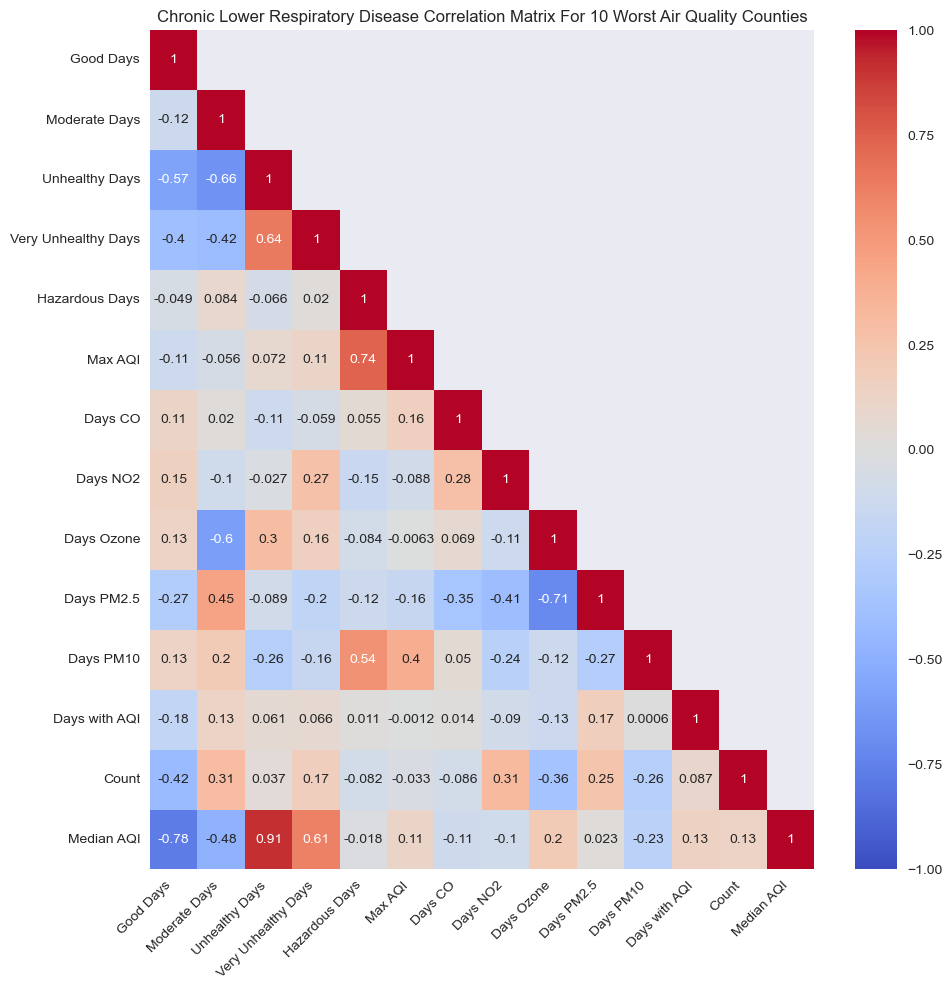

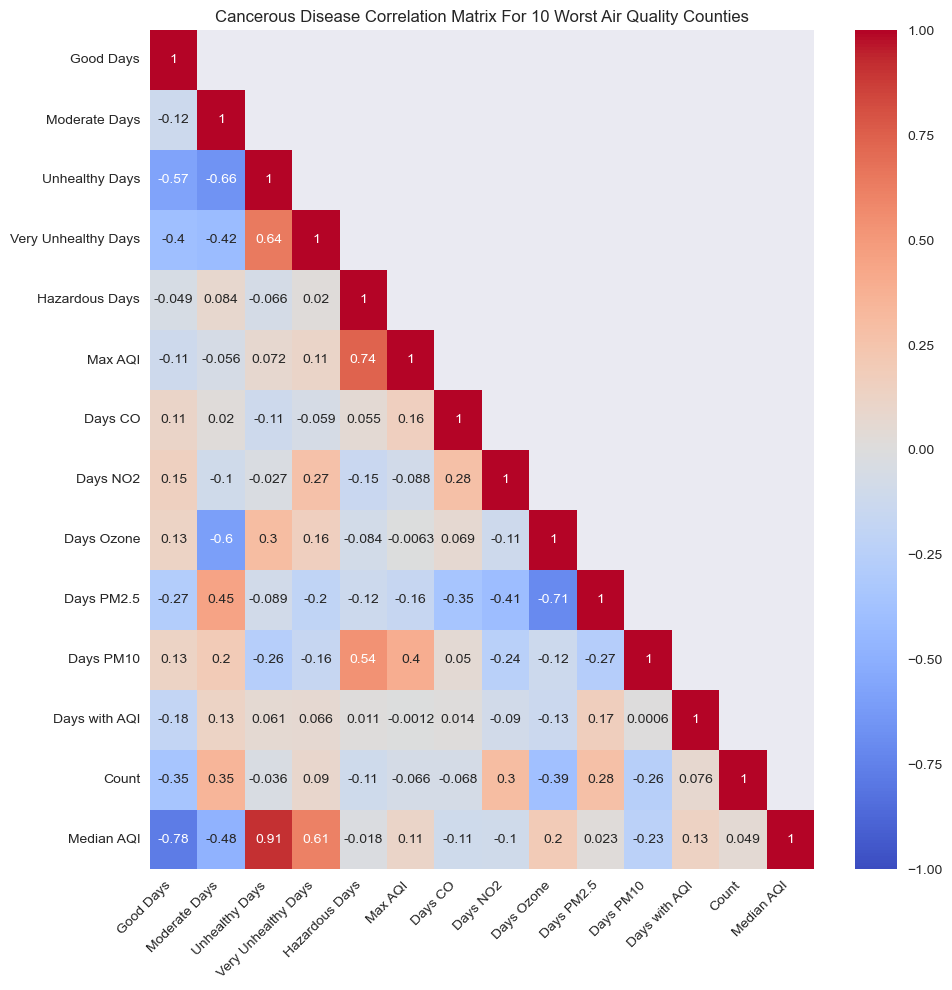

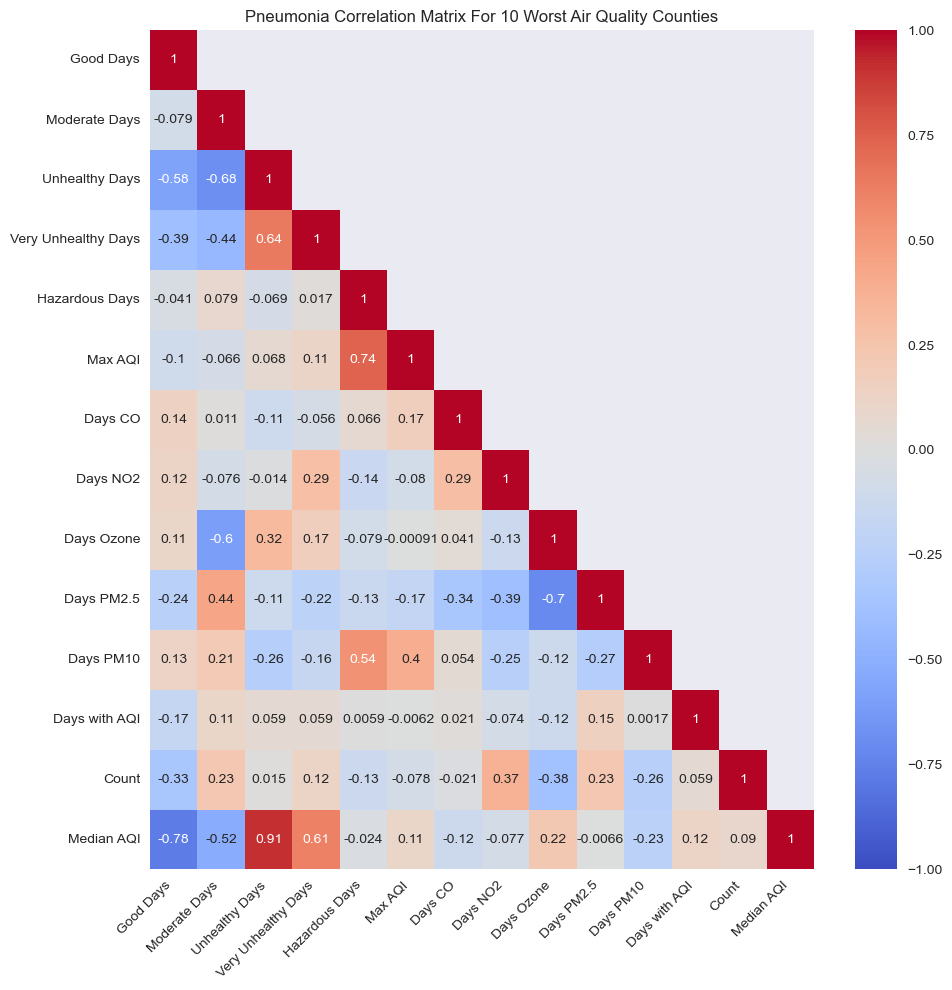

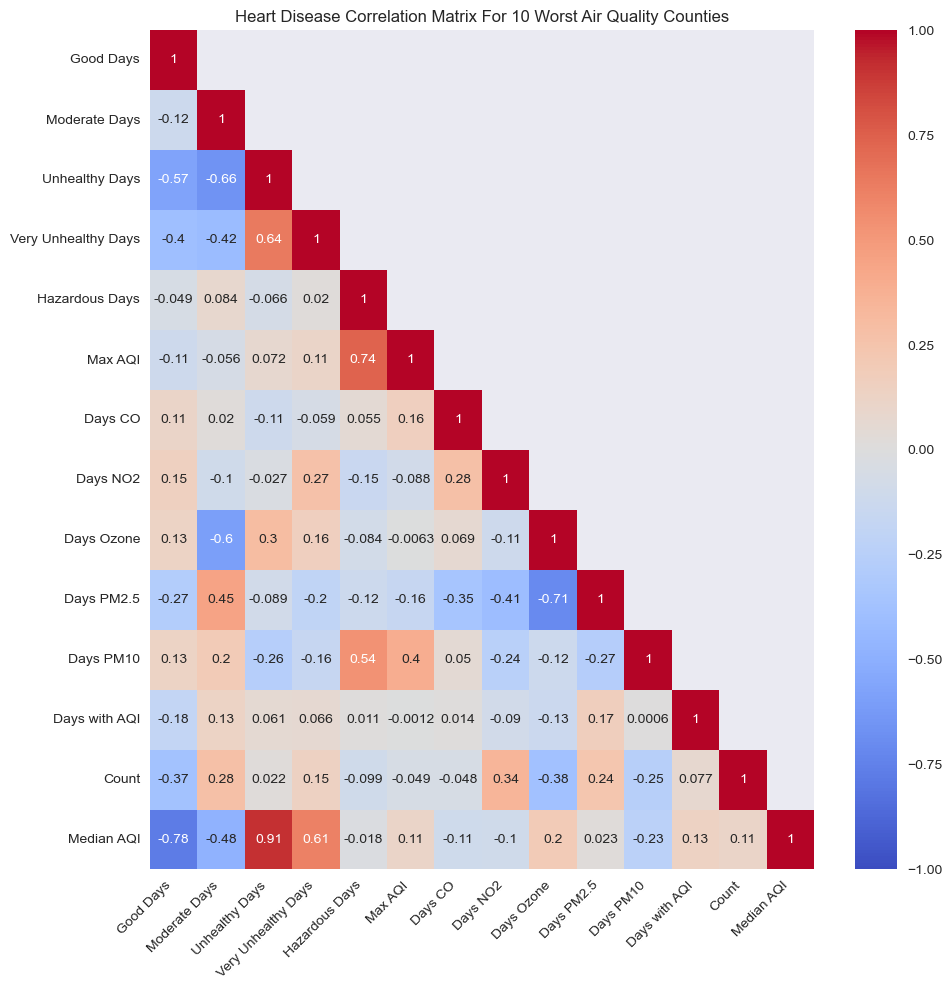

In [83]:
# CLD
get_correlation_plot(cld_corr, 'Chronic Lower Respiratory Disease Correlation Matrix For 10 Worst Air Quality Counties')

# CAN
get_correlation_plot(can_corr, 'Cancerous Disease Correlation Matrix For 10 Worst Air Quality Counties')

# PNF
get_correlation_plot(pneumonia_corr, 'Pneumonia Correlation Matrix For 10 Worst Air Quality Counties')

# HTD
get_correlation_plot(heart_disease_corr, 'Heart Disease Correlation Matrix For 10 Worst Air Quality Counties')

In the above correlation plots, we are interested in the relationship between the variabel `count` and the air quality metrics. We note a number of interesting relationships:

1. A negative pearson value, such as the correlation between `Good Days` and `Count` is as expected, as the number of days with good air quality goes up, the number of deaths from diseases related to poor air quality goes down. 


2. `Moderate Days` and `Days NO2` both have positive Pearson values with `Count`. Moderate Days was not one of the air-quality metrics that was found to have a granger-causal relationsip to the 4 causes of death studied and we note that the EPA states that *"Moderate air quality "Air quality is acceptable; however, there may be some health concern for a small number of unusually sensitive people. While EPA cannot identify these people, studies indicate that there are people who experience health effects when air quality is in the moderate range."*[[SOURCE](https://www.epa.gov/pmcourse/patient-exposure-and-air-quality-index)] -- reinforcing our findings. NO2 however, did have a granger causing relationship, primarily to pneumonia and chronic lower respiratory diseases, and we note the EPA's statement on NO2: "*Breathing air with a high concentration of NO2 can irritate airways in the human respiratory system. Such exposures over short periods can aggravate respiratory diseases, particularly asthma, leading to respiratory symptoms (such as coughing, wheezing or difficulty breathing), hospital admissions and visits to emergency rooms. Longer exposures to elevated concentrations of NO2 may contribute to the development of asthma and potentially increase susceptibility to respiratory infections. People with asthma, as well as children and the elderly are generally at greater risk for  the health effects of NO2."* [[SOURCE](https://www.epa.gov/no2-pollution/basic-information-about-no2)]

# Line Plots From Annual Granger Tests

Annual Data

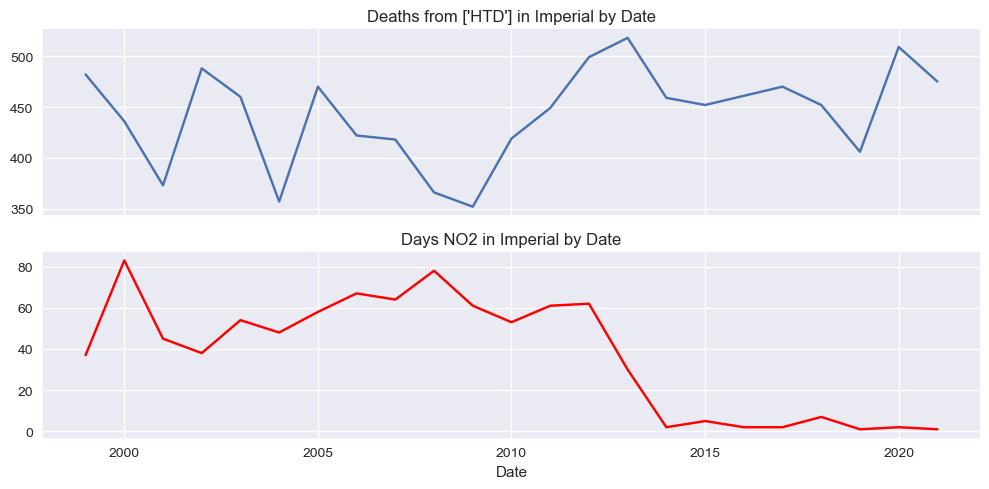

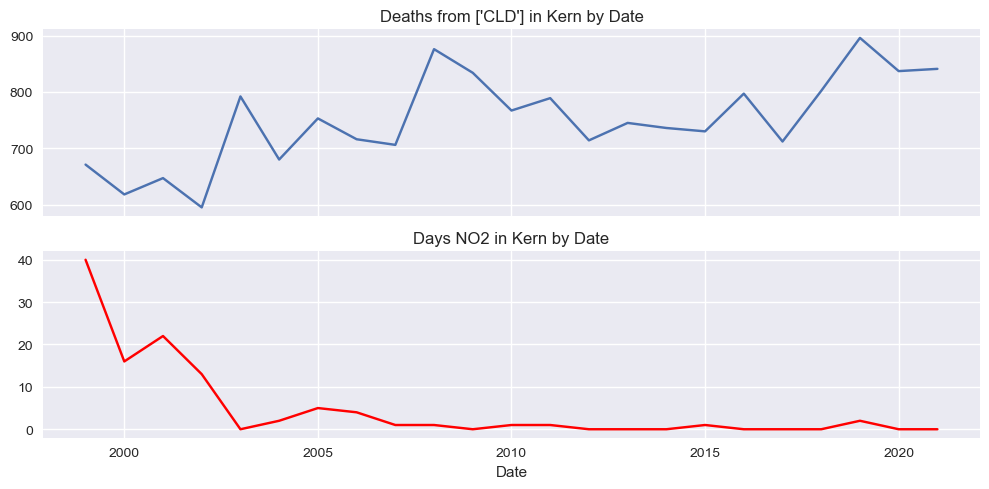

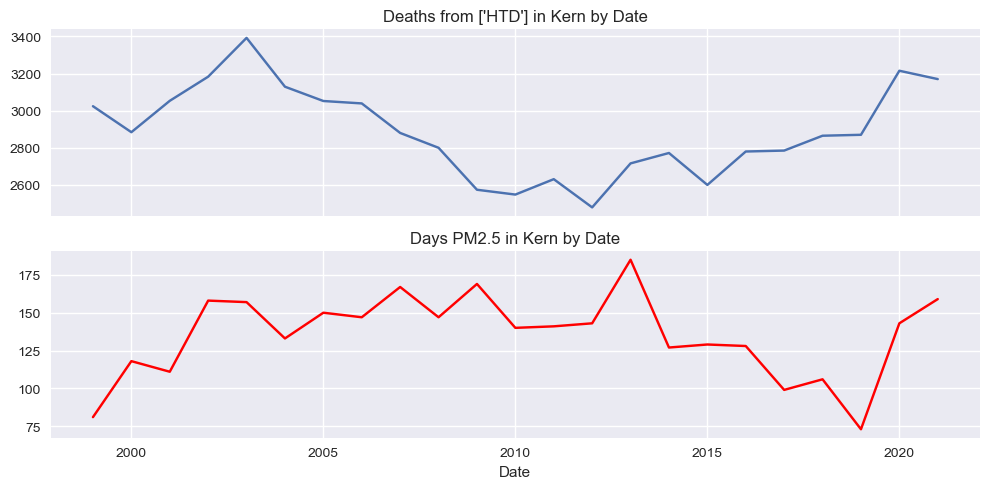

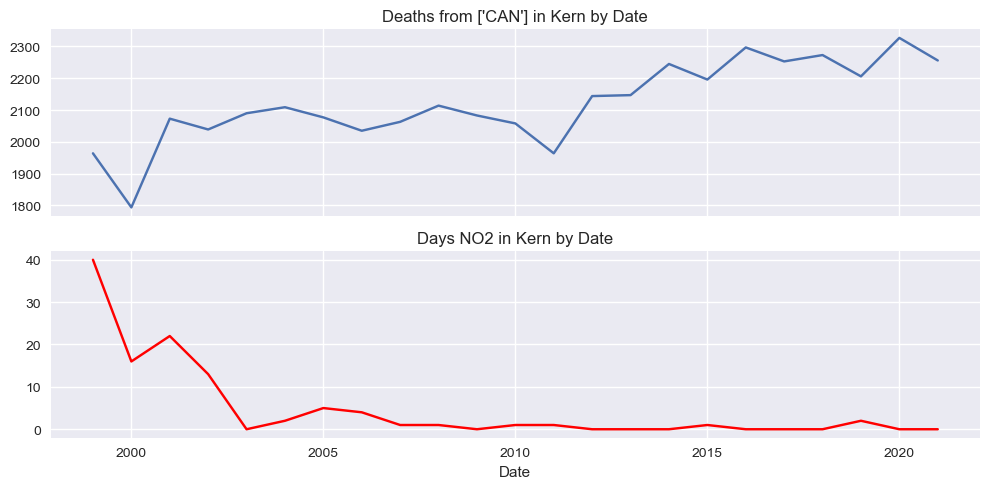

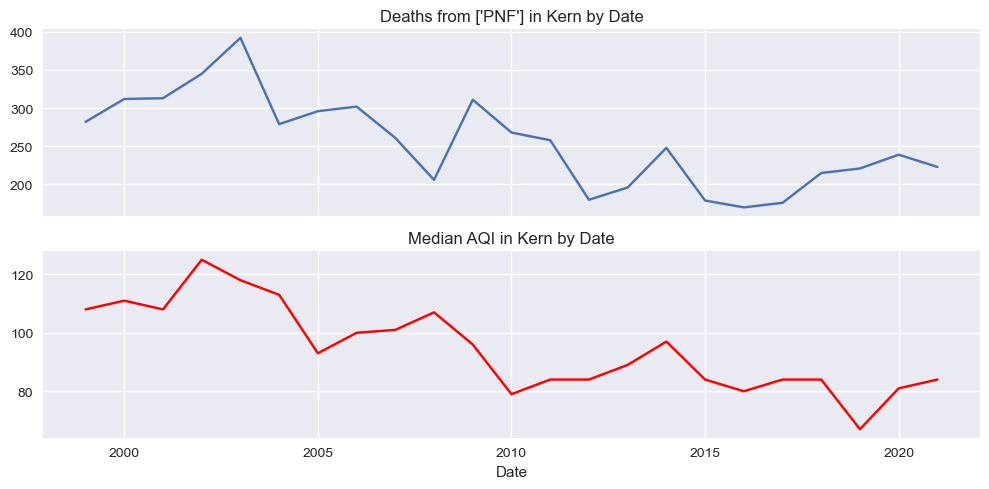

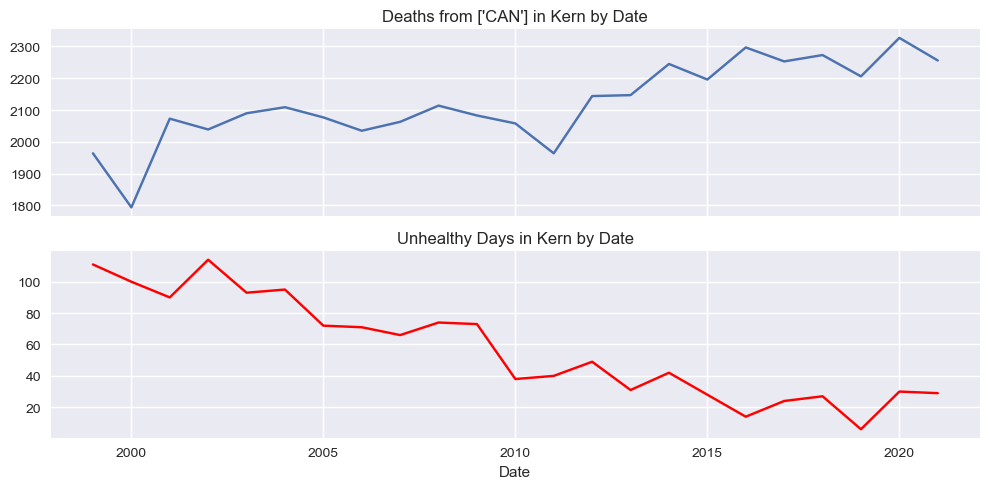

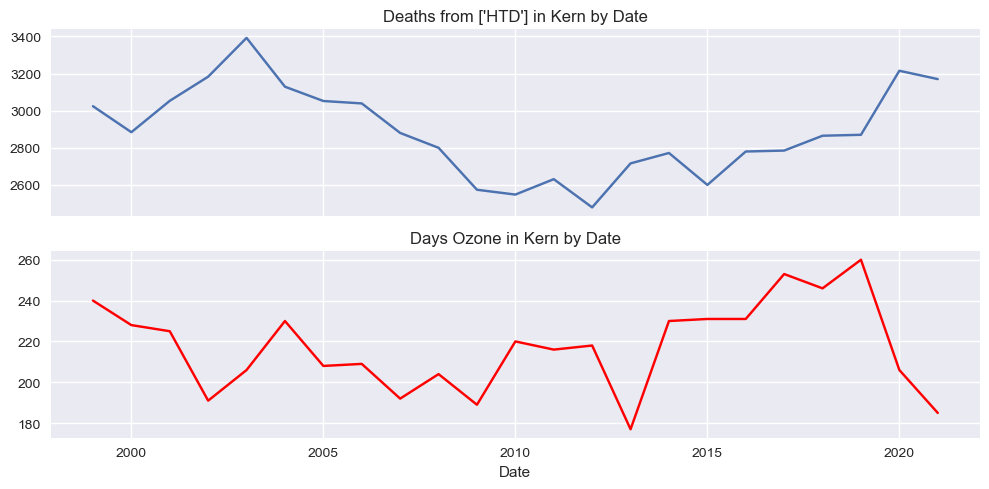

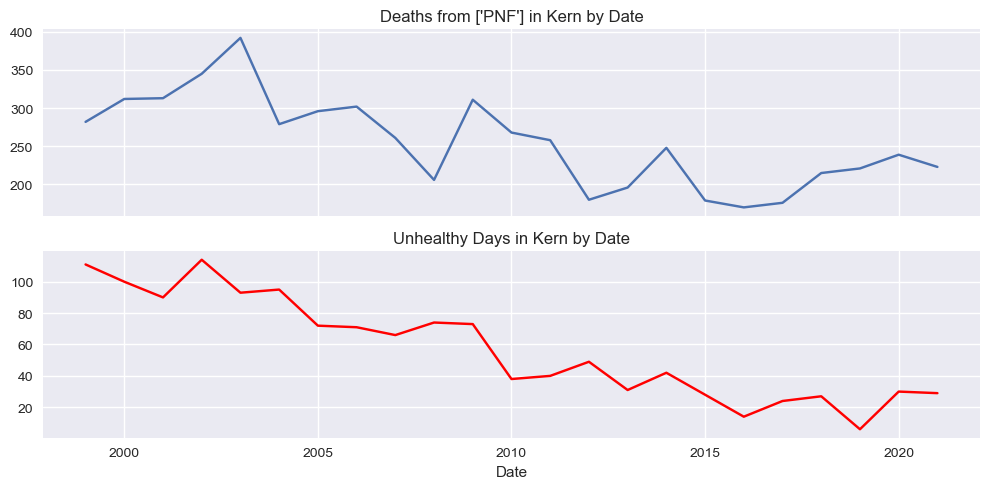

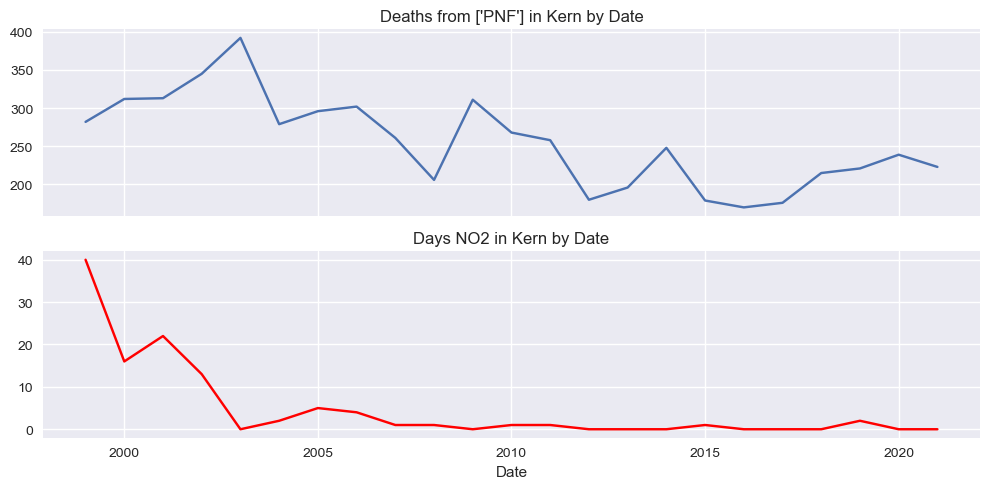

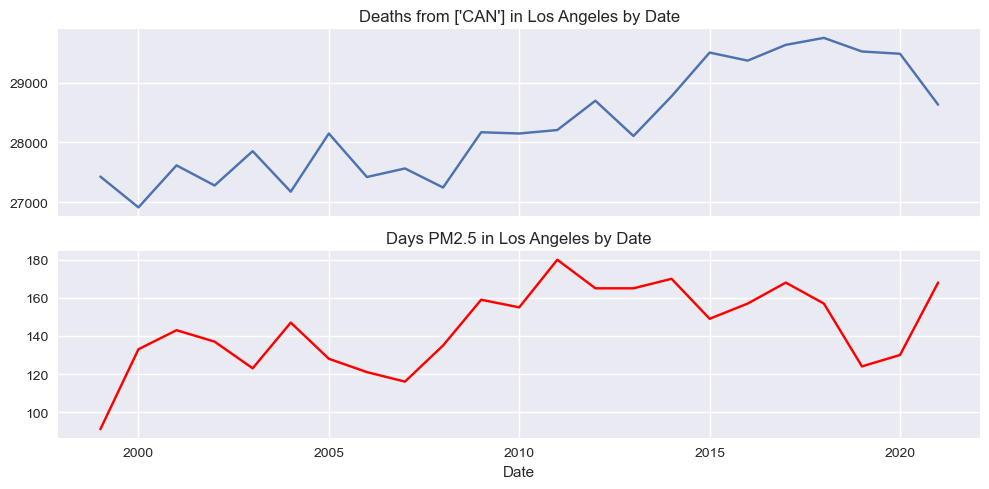

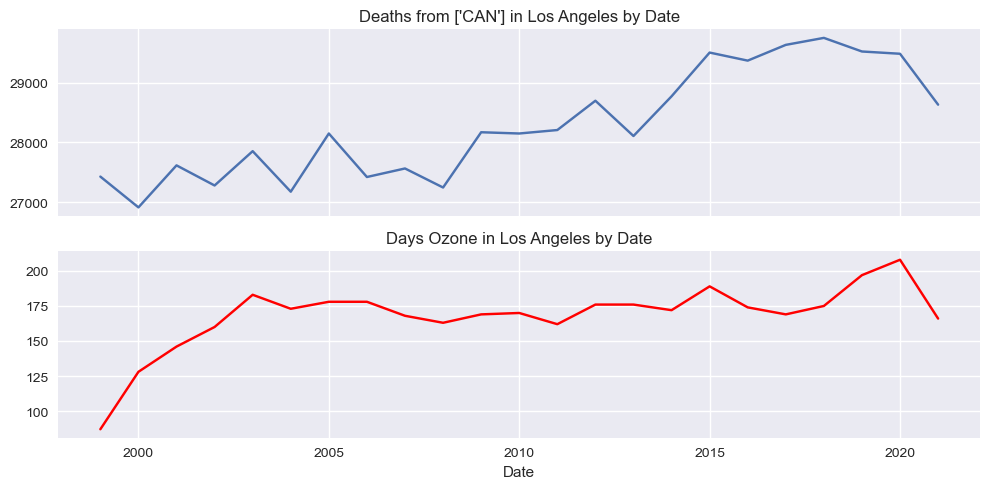

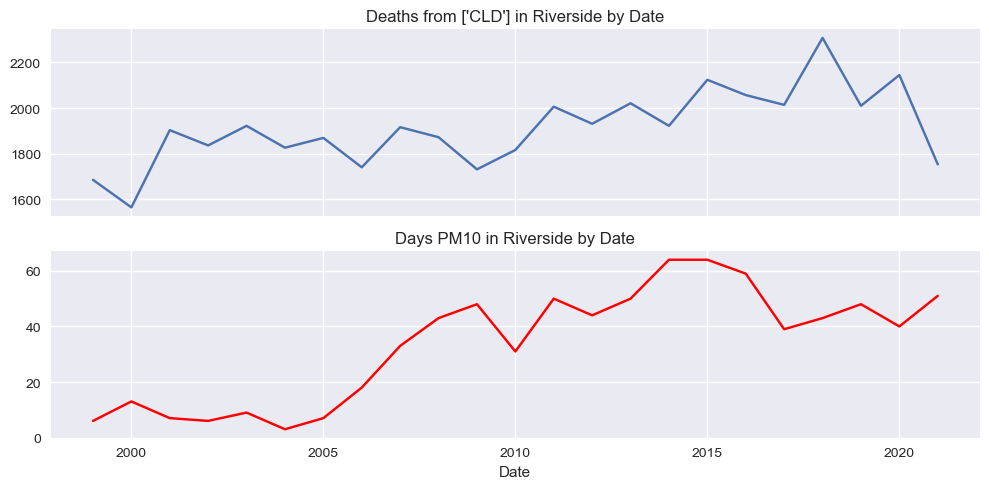

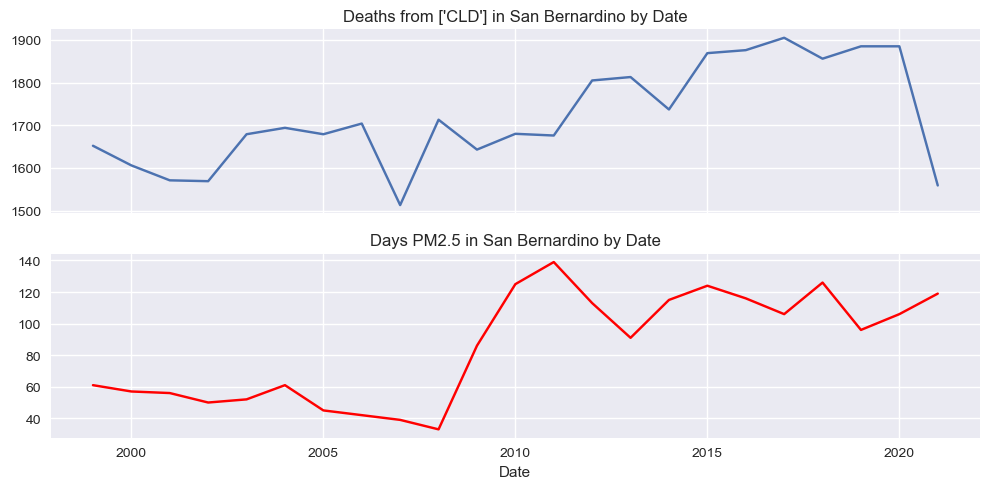

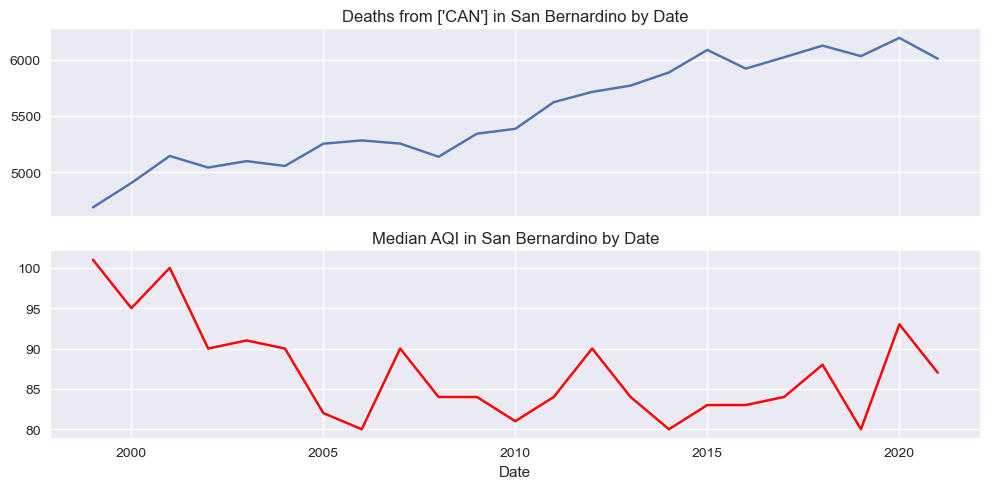

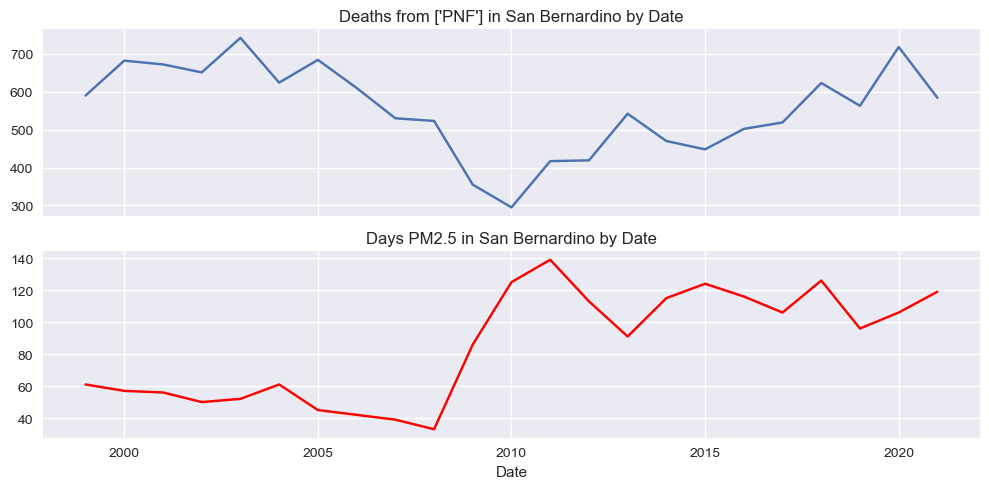

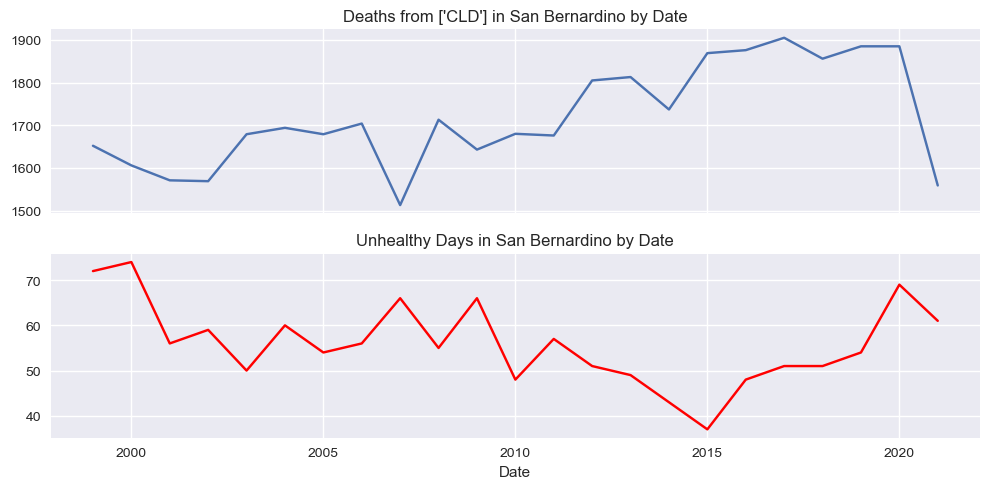

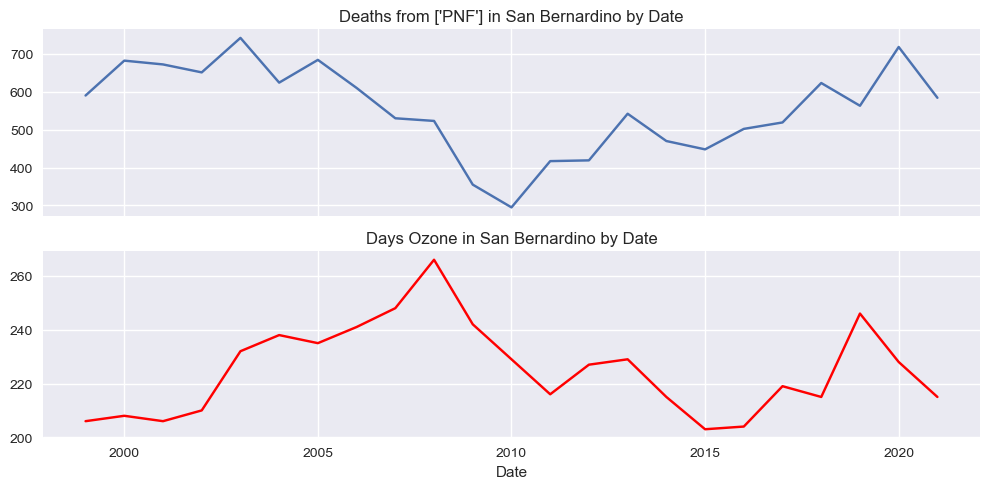

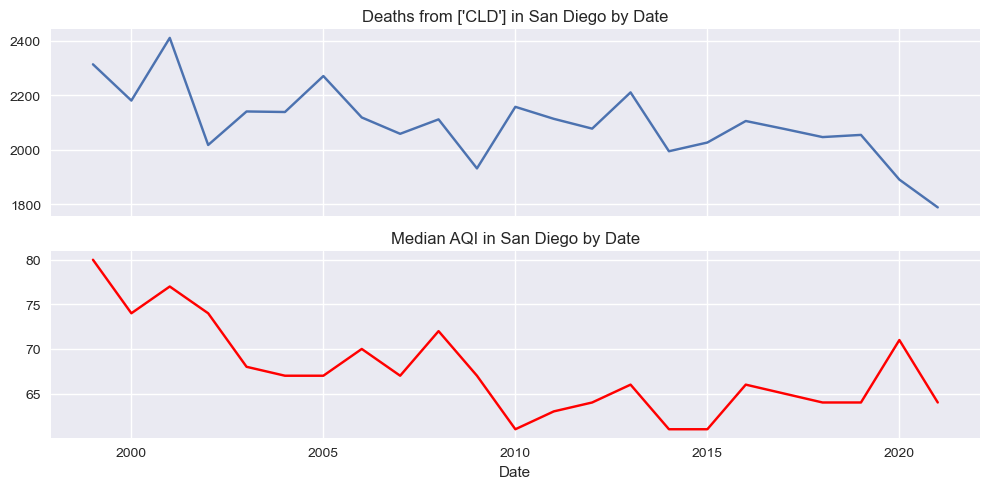

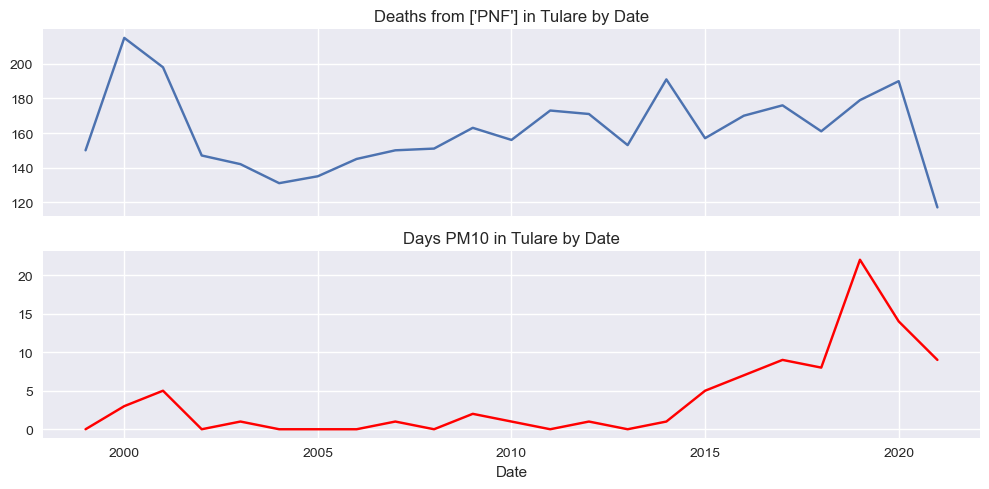

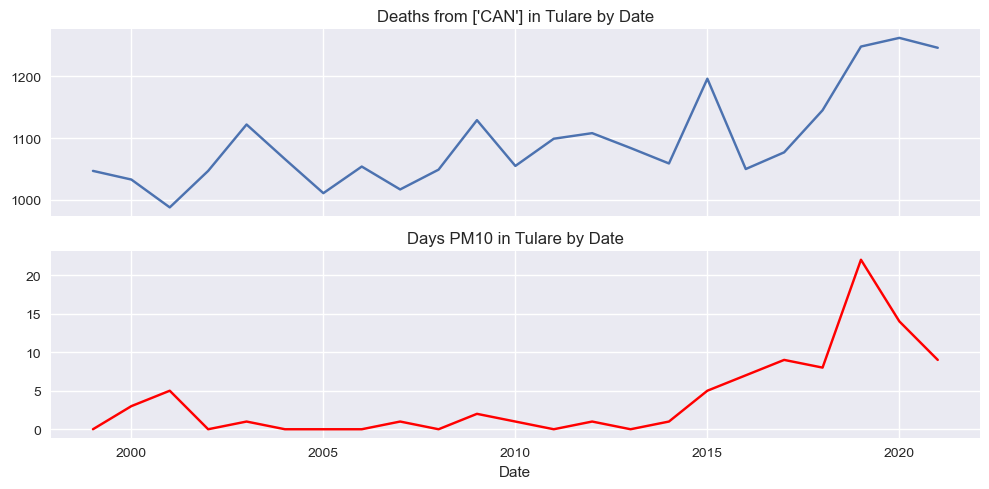

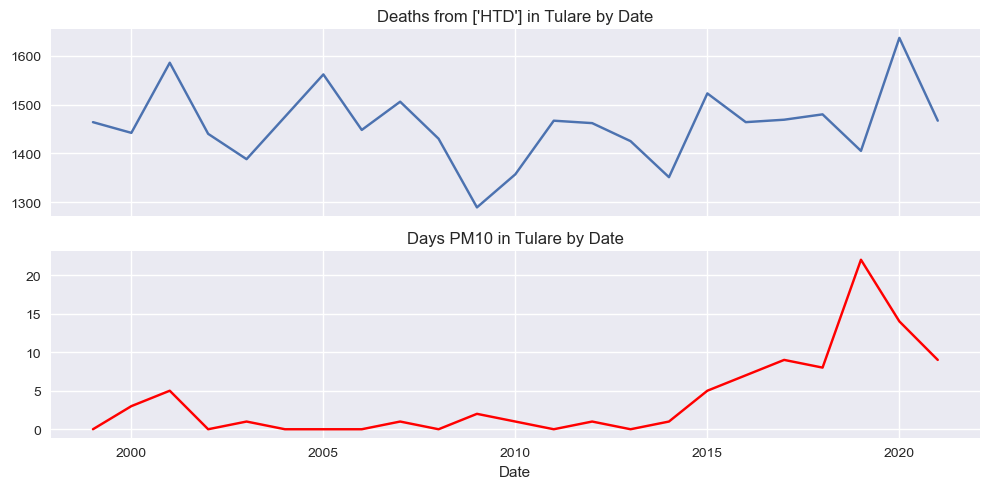

In [84]:
for county in granger_df.iterrows():
    try:
        plot_air_quality_by_county(county[1]['County'], county[1]['air_qual_metric'], [county[1]['Cause']], df=mortality, air_qual_df=ca_df)
    except:
        pass

The line plots above present the findings from the granger causality test in a graphical format. For each county, cause of death and pollutant found to have a statistically significant relationship a line plot is drawn. 

**Obvious Relationships**

In some cases, the plots show an obvious relationship for example, the line plots of deaths from pneumonia and Median AQI and Unhealthy days for Kern county show a strong relationship, as do deaths from chronic lower respiratory diseases and Median AQI in San Diego County. 

**More Abstract Relationships**

In other cases, particularly with cancer deaths, this relationship is not obvious visually, likely owing to the lag component of time series analysis. This is intuitive, as it is unlikely that the cause of your cancer results in your death in the same year of the cancer's oncogenesis. 

# Granger Tests and Plots For Monthly Data

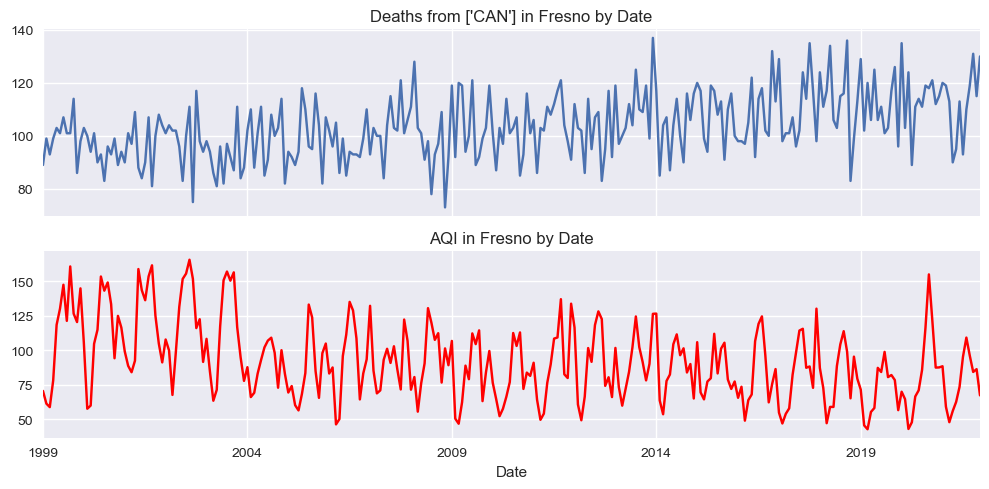

Air Quality metric: (AQI) Granger causes deaths from respiratory diseases in Fresno county with p_value of 0.030338266113974638 and lag of 1


('Fresno', 'AQI', 0.030338266113974638, 1, 'CAN')

In [85]:
plot_air_quality_by_county(county='Fresno', air_qual='AQI', diseases=['CAN'], df=can_monthly, air_qual_df=can_monthly)
air_qual_test(can_monthly, 'AQI')

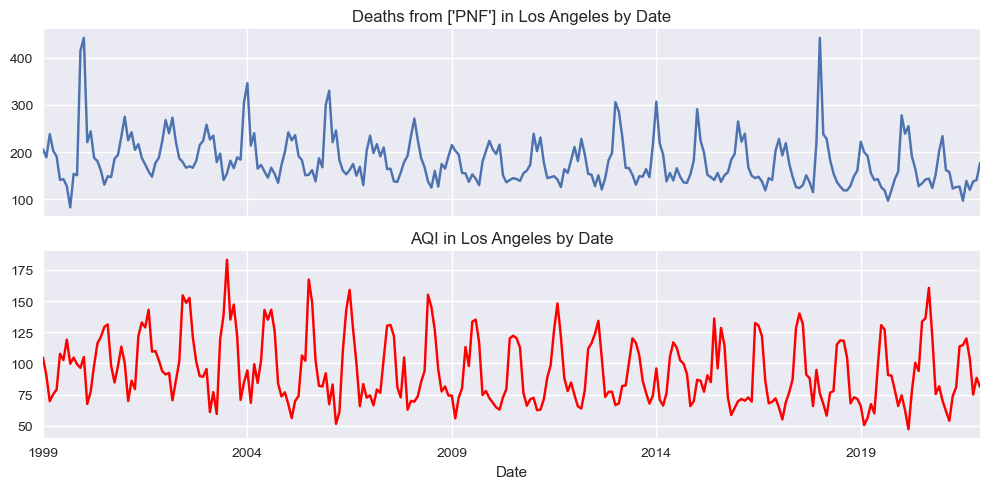

Air quality metric not in dataset.
Air quality metric not in dataset.
Air quality metric not in dataset.
Air quality metric not in dataset.
Air quality metric not in dataset.
Air Quality metric: (AQI) Granger causes deaths from respiratory diseases in Los Angeles county with p_value of 0.0012576841495153576 and lag of 1


('Los Angeles', 'AQI', 0.0012576841495153576, 1, 'PNF')

In [86]:
plot_air_quality_by_county(county = 'Los Angeles', air_qual = 'AQI', diseases = ['PNF'], df = pneumonia_monthly, air_qual_df = pneumonia_monthly)
air_qual_test(pneumonia_monthly, 'AQI')

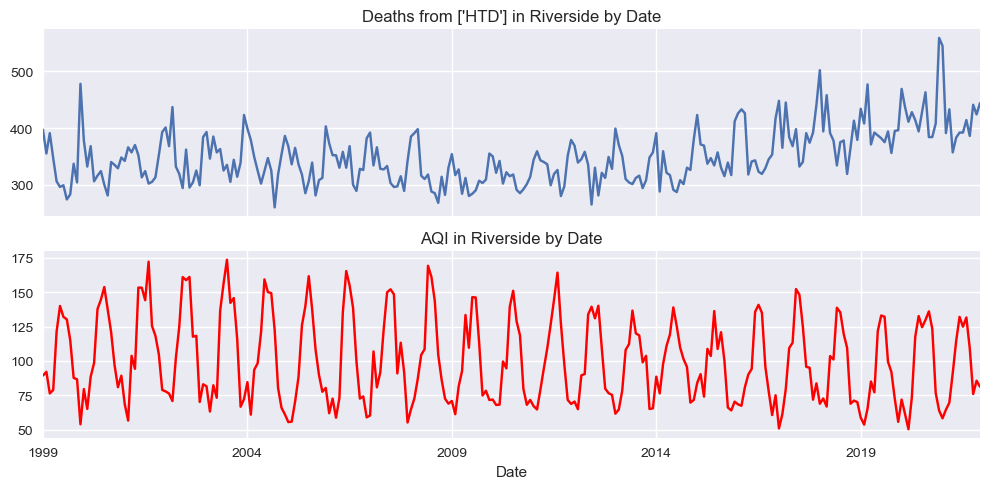

Air Quality metric: (AQI) Granger causes deaths from respiratory diseases in Riverside county with p_value of 1.0496660011008415e-06 and lag of 1


('Riverside', 'AQI', 1.0496660011008415e-06, 1, 'HTD')

In [87]:
plot_air_quality_by_county(county = 'Riverside', air_qual = 'AQI', diseases = ['HTD'], df = heart_disease_monthly, air_qual_df = heart_disease_monthly)
air_qual_test(heart_disease_monthly, 'AQI')

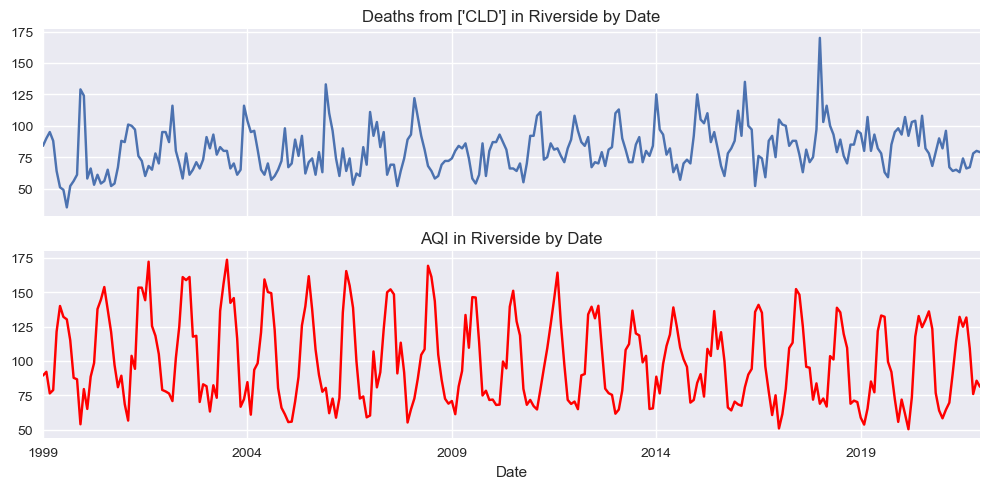

Air quality metric not in dataset.
Air Quality metric: (AQI) Granger causes deaths from respiratory diseases in Riverside county with p_value of 3.2588917834507315e-14 and lag of 1


('Riverside', 'AQI', 3.2588917834507315e-14, 1, 'CLD')

In [88]:
plot_air_quality_by_county(county = 'Riverside', air_qual = 'AQI', diseases = ['CLD'], df = cld_monthly, air_qual_df = cld_monthly)
air_qual_test(cld_monthly, 'AQI')

The three plots above present the same analysis conducted at the annual level but instead using monthly data from 1999-2021. 

There are fewer plots as the monthly data only account for Median AQI and thus the Granger Causality tests found less statistically significant relationships. 

**Seasonality In Time Series** 

The plots above are useful in illustrating the seasonal aspect of air pollution in some counties California. Seasonality in time series analysis refers to regular variations in patterns occurring at predictable intervals. For example if we look at the median AQI for Riverside County above, we can see that the AQI varies on a fairly stable basis. 

---

# III. EDA Conclusions

1. We found a number of interesting statistical relationships that exist between toxic air-pollution and four major causes of death: Heart Disease, Chronic Lower Respiratory Diseases, Cancer, and Pneumonia. 

    - Of the 58 counties in California, 9 of the top 10 measured by highest median AQI are in Southern California. 


2. Using Granger Causality time series tests, we were able to determine potential statistically significant causal relationships between various pollutant types and counties in Southern California. 

3. We found that even though some relationships pass statistical hypothesis tests, their relationship remains potentially spurious and needs a more rigorous analysis to prove any causal or correlative relationship. To this end, our project has included two separate EDA notebooks to further investigate the impact of air pollution: 
    - We have a notebook dedicated to the investigation of cancer incidence and air pollution across all CA counties where ARIMAX forecasting is conducted various cancer incidence rates and air pollution
    - We have a notebook dedicated to the investigation of air pollutions effects on ancillary negative health outcomes, such as low birthweight. 
